W związku ze zbliżającymi się wyborami prezydenckimi 2025 postanowiłem przeprowadzić szybki, ale pogłębiony przegląd komentarzy zamieszczanych przez użytkowników YouTube w kontekście debaty prezydenckiej. Celem projektu było uchwycenie autentycznych emocji, opinii oraz sposobu postrzegania kandydatów przez społeczność internetową — poza oficjalnymi narracjami medialnymi i tradycyjnymi sondażami.

Analizie poddano 141 136 komentarzy, zebranych z 330 losowo wybranych filmów opublikowanych w ciągu ostatniego tygodnia, zawierających w tytule frazę „debata prezydencka”. Różnorodność źródeł i losowy charakter doboru materiałów pozwoliły uchwycić szerokie spektrum opinii — od emocjonalnych deklaracji poparcia, przez konstruktywną krytykę, po komentarze nacechowane hejtem czy ironią.

Analiza została przeprowadzona z wykorzystaniem technologii przetwarzania języka naturalnego (NLP), co umożliwiło automatyczne i precyzyjne wydobycie z komentarzy takich informacji jak:

– deklaracje poparcia dla konkretnych kandydatów
– emocje wyrażone w komentarzach (zarówno pozytywne, jak i negatywne)
– najczęściej poruszane tematy i wątki
– przezwiska oraz prześmiewcze określenia kandydatów
– częstość użycia haseł i sloganów wyborczych

W trosce o przejrzystość procesu analitycznego, cały kod źródłowy, opis metodologii oraz dane pomocnicze zostały udostępnione bezpośrednio w notebooku. Pliki te — wraz z pełnym repozytorium projektu — są dostępne na moim profilu GitHub, umożliwiając każdemu weryfikację, replikację lub rozwinięcie analizy.

Choć projekt nie ma charakteru reprezentatywnego dla ogółu społeczeństwa — opiera się bowiem wyłącznie na głosach użytkowników YouTube — to stanowi ciekawe i wartościowe źródło wiedzy o nastrojach społecznych obecnych w przestrzeni cyfrowej.

Celem projektu było pokazanie, że:

– sondaże telewizyjne nie zawsze oddają realne emocje społeczne, a często je upraszczają
– komentarze internetowe są źródłem bardziej bezpośrednich, szczerych reakcji
– nawet mniejsze komitety i postacie spoza głównego nurtu mogą silnie rezonować w mediach społecznościowych, kształtując debatę publiczną

Wybory to nie tylko przywilej, ale i odpowiedzialność. Każdy głos, szczególnie w pierwszej turze, ma znaczenie. To właśnie wtedy mogą pojawić się nowe siły polityczne i szansa na realną zmianę.

Zachęcam do głosowania zgodnie z własnym sumieniem, do samodzielnego myślenia i nieulegania medialnym narracjom. Bądźmy aktywnymi uczestnikami debaty publicznej — z odwagą, ale i szacunkiem.

Nasze decyzje przy urnie wyborczej kształtują przyszłość tego kraju. Nie dajmy, by ktoś wybrał za nas.



1. **CELL INDEX: 3**  
    Importowane są biblioteki: `pandas` do pracy z danymi, `transformers` do przetwarzania języka naturalnego (NLP), oraz `torch` do obliczeń tensorowych. Przygotowywane są narzędzia do analizy tekstu i modelowania.

2. **CELL INDEX: 4**  
    Za pomocą narzędzia `yt-dlp` pobierane są metadane 1000 filmów z YouTube zawierających frazę "debata prezydencka" opublikowanych po 7 maja 2024 roku. Wyniki są zapisywane w pliku tekstowym `debata_filmy.txt`.

3. **CELL INDEX: 5**  
    Pobierane są komentarze z filmów wymienionych w pliku `debata_filmy.txt` za pomocą biblioteki `youtube_comment_downloader`. Komentarze są przetwarzane i zapisywane w pliku CSV `komentarze_debaty.csv` jako tabela z kolumnami: `video_id`, `time`, `author`, `text`.

In [2]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

c:\Users\lukas\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
! yt-dlp "ytsearch1000:debata prezydencka after:2024-05-07" 

In [ ]:
from youtube_comment_downloader import YoutubeCommentDownloader
import pandas as pd

downloader = YoutubeCommentDownloader()
plik_wejsciowy = "debata_filmy.txt"
wszystkie_komentarze = []

with open(plik_wejsciowy, encoding="utf-8") as f:
    for linia in f:
        try:
            _, video_id, _ = linia.strip().split(" ||| ")
            print(f"Pobieram komentarze dla: {video_id}")
            url = f"https://www.youtube.com/watch?v={video_id}"

            for komentarz in downloader.get_comments_from_url(url, sort_by=0):
                wszystkie_komentarze.append({
                    "video_id": video_id,
                    "time": komentarz["time"],
                    "author": komentarz["author"],
                    "text": komentarz["text"]
                })

        except Exception as e:
            print(f"Błąd przy {linia.strip()}: {e}")

# Zapis do pliku CSV
df = pd.DataFrame(wszystkie_komentarze)
df.to_csv("komentarze_debaty.csv", index=False, encoding="utf-8-sig")
print("✅ Gotowe! Komentarze zapisane do komentarze_debaty.csv")

In [30]:
print(df.columns)

Index(['time', 'author', 'text'], dtype='object')


In [42]:
import pandas as pd
import re


df = pd.read_csv("komentarze_debaty.csv")  

text = " ".join(df["text"].astype(str).tolist()).lower()

kandydaci = {
    "Karol Nawrocki": ["nawrocki", "nawrockiego", "nawrockiemu", "nawrockim", "nawrockich"],
    "Sławomir Mentzen": ["mentzen", "mentzena", "mentzenowi", "mentzenem", "mentzenie"],
    "Szymon Hołownia": ["hołownia", "hołowni", "hołownię", "hołownią", "hołownio"],
    "Grzegorz Braun": ["braun", "brauna", "braunowi", "braunem", "braunie"],
    "Krzysztof Stanowski": ["stanowski", "stanowskiego", "stanowskiemu", "stanowskim", "stanowskich"],
    "Rafał Trzaskowski": ["trzaskowski", "trzaskowskiego", "trzaskowskiemu", "trzaskowskim", "trzaskowskich"],
    "Marek Woch": ["woch", "wocha", "wochowi", "wochem", "wochu"],
    "Marek Jakubiak": ["jakubiak", "jakubiaka", "jakubiakowi", "jakubiakiem", "jakubiaku"],
    "Artur Bartoszewicz": ["bartoszewicz", "bartoszewicza", "bartoszewiczowi", "bartoszewiczem", "bartoszewiczu"],
    "Joanna Senyszyn": ["senyszyn"],
    "Adrian Zandberg": ["zandberg", "zandberga", "zandbergowi", "zandbergiem", "zandbergu"],
    "Magdalena Biejat": ["biejat"],
    "Macej Maciak": ["maciak", "maciaka", "maciakowi", "maciakiem", "maciaku"]

}

# Liczenie wystąpień wszystkich form nazwisk
wyniki = {}
for nazwisko, formy in kandydaci.items():
    suma = 0
    for forma in formy:
        suma += len(re.findall(rf"\b{forma}\b", text))
    wyniki[nazwisko] = suma

# Posortowany wynik
for nazwisko, liczba in sorted(wyniki.items(), key=lambda x: x[1], reverse=True):
    print(f"{nazwisko}: {liczba}")


Grzegorz Braun: 16166
Rafał Trzaskowski: 10916
Sławomir Mentzen: 8437
Karol Nawrocki: 7317
Krzysztof Stanowski: 6951
Szymon Hołownia: 4781
Macej Maciak: 4101
Artur Bartoszewicz: 3091
Marek Jakubiak: 1840
Magdalena Biejat: 1743
Adrian Zandberg: 1624
Joanna Senyszyn: 1441
Marek Woch: 701


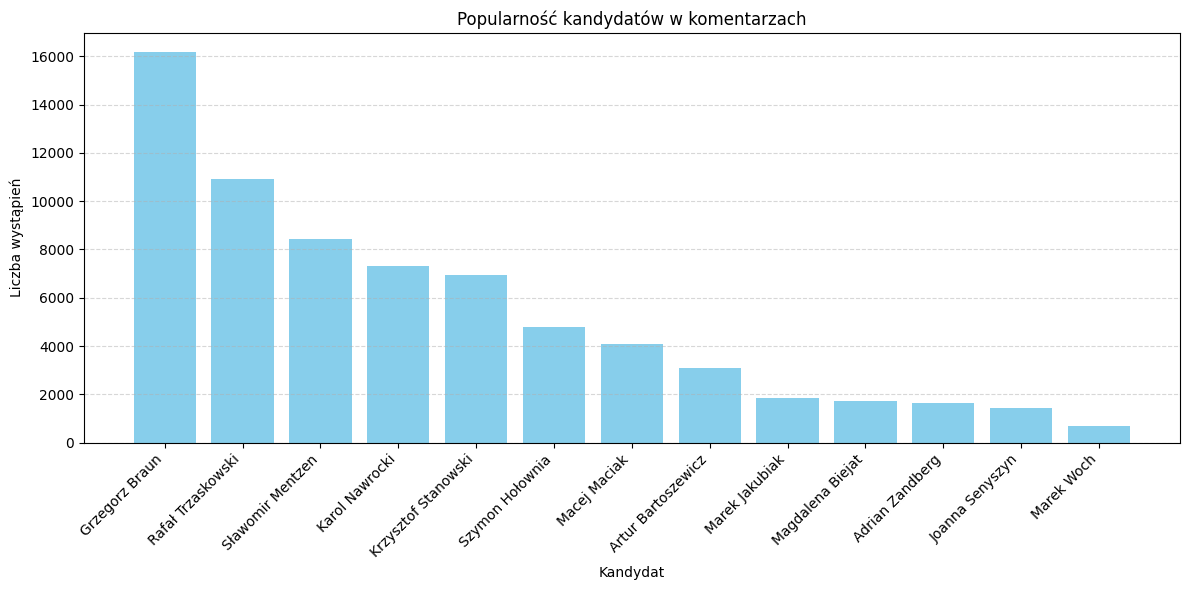

In [43]:
import matplotlib.pyplot as plt

# Załóżmy, że masz już zmienną `wyniki` z poprzedniego kroku:
# np. wyniki = {"Sławomir Mentzen": 10, "Szymon Hołownia": 9, ...}

# Posortuj dane malejąco
sorted_wyniki = dict(sorted(wyniki.items(), key=lambda x: x[1], reverse=True))

# Wykres
plt.figure(figsize=(12, 6))
plt.bar(sorted_wyniki.keys(), sorted_wyniki.values(), color='skyblue')
plt.title("Popularność kandydatów w komentarzach")
plt.xlabel("Kandydat")
plt.ylabel("Liczba wystąpień")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [54]:
import pandas as pd
import re

# Wczytanie danych
df = pd.read_csv("komentarze_debaty.csv")  # upewnij się, że kolumna to 'text'

# Ustawienia
synonimy_glosowania = [
   "zagłosuję", "zaglosuje", "głosuję", "glosuje", "oddaję głos", "oddam głos",
    "oddaje głos", "oddałem głos", "zagłosowałem", "głos na", "mój głos dla",
    "popieram", "poparłem", "popieram kandydaturę", "jestem za", "jestem z",
    "stawiam na", "wybieram", "mój wybór", "będę głosować", "będę głosował",
    "moje poparcie", "mój kandydat", "mój faworyt", "głosuję na", "głos dla",
    "mam zamiar głosować", "głos oddany", "stoję za", "idę na wybory dla", 
    "będę głosować na", "mój głos idzie na", "liczę na", "trzymam kciuki za",
    "pełne poparcie", "całym sercem za", "kandydat godny poparcia", "zdecydowanie za"
]

kandydaci = {
    "Karol Nawrocki": ["nawrocki", "nawrockiego", "nawrockiemu", "nawrockim", "nawrockich"],
    "Sławomir Mentzen": ["mentzen", "mentzena", "mentzenowi", "mentzenem", "mentzenie"],
    "Szymon Hołownia": ["hołownia", "hołowni", "hołownię", "hołownią", "hołownio"],
    "Grzegorz Braun": ["braun", "brauna", "braunowi", "braunem", "braunie"],
    "Krzysztof Stanowski": ["stanowski", "stanowskiego", "stanowskiemu", "stanowskim", "stanowskich"],
    "Rafał Trzaskowski": ["trzaskowski", "trzaskowskiego", "trzaskowskiemu", "trzaskowskim", "trzaskowskich"],
    "Marek Woch": ["woch", "wocha", "wochowi", "wochem", "wochu"],
    "Marek Jakubiak": ["jakubiak", "jakubiaka", "jakubiakowi", "jakubiakiem", "jakubiaku"],
    "Artur Bartoszewicz": ["bartoszewicz", "bartoszewicza", "bartoszewiczowi", "bartoszewiczem", "bartoszewiczu"],
    "Joanna Senyszyn": ["senyszyn"],
    "Adrian Zandberg": ["zandberg", "zandberga", "zandbergowi", "zandbergiem", "zandbergu"],
    "Magdalena Biejat": ["biejat"],
    "Maciej Maciak": ["maciak", "maciaka", "maciakowi", "maciakiem", "maciaku"]
}

# Inicjalizacja wyniku
deklaracje_glosu = {k: 0 for k in kandydaci}

# Analiza komentarzy
for komentarz in df["text"].astype(str):
    komentarz_lower = komentarz.lower()
    for kandydat, formy in kandydaci.items():
        if any(re.search(rf"\b{forma}\b", komentarz_lower) for forma in formy):
            if any(slowo in komentarz_lower for slowo in synonimy_glosowania):
                deklaracje_glosu[kandydat] += 1

# Wyświetlenie wyników
for kandydat, liczba in sorted(deklaracje_glosu.items(), key=lambda x: x[1], reverse=True):
    print(f"{kandydat}: {liczba} deklaracji głosu")


Grzegorz Braun: 597 deklaracji głosu
Sławomir Mentzen: 314 deklaracji głosu
Rafał Trzaskowski: 311 deklaracji głosu
Karol Nawrocki: 259 deklaracji głosu
Krzysztof Stanowski: 139 deklaracji głosu
Maciej Maciak: 133 deklaracji głosu
Artur Bartoszewicz: 119 deklaracji głosu
Szymon Hołownia: 88 deklaracji głosu
Magdalena Biejat: 81 deklaracji głosu
Adrian Zandberg: 77 deklaracji głosu
Marek Jakubiak: 67 deklaracji głosu
Joanna Senyszyn: 49 deklaracji głosu
Marek Woch: 19 deklaracji głosu


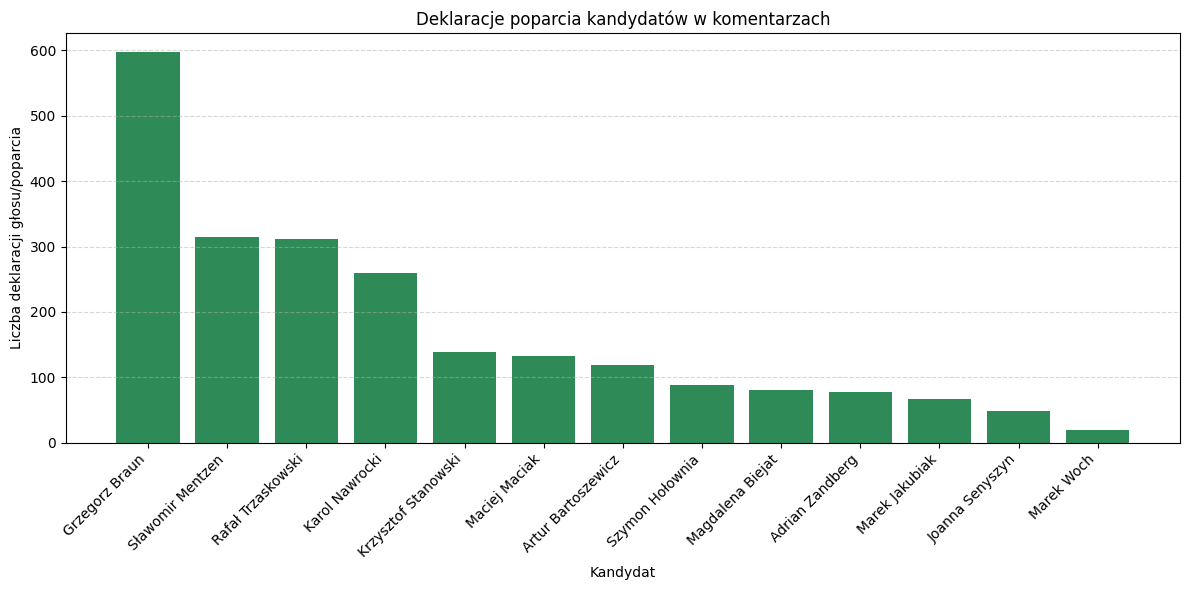

In [55]:
sorted_deklaracje = dict(sorted(deklaracje_glosu.items(), key=lambda x: x[1], reverse=True))

# Tworzenie wykresu
plt.figure(figsize=(12, 6))
plt.bar(sorted_deklaracje.keys(), sorted_deklaracje.values(), color='seagreen')
plt.title("Deklaracje poparcia kandydatów w komentarzach")
plt.xlabel("Kandydat")
plt.ylabel("Liczba deklaracji głosu/poparcia")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [56]:
synonimy_przegranej = [
    # Klasyczne przegranie
    "przegra", "przegrywa", "przegrał", "przegrany", "poległ", "przepadł", "odpadł", "wyeliminowany",
    "pokonany", "nie wygra", "nie dał rady", "dostał baty", "został rozbity",

    # Porażka / kompromitacja
    "porażka", "kompromitacja", "wstyd", "żenada", "obciach", "katastrofa", "dramat", "żałosny", "skończony",
    "dostał po twarzy", "rozjechany", "zmiażdżony", "zniszczony", "został zniszczony",

    # "Zaorany" styl YouTube / memy
    "zaorany", "zaorali go", "zrobili go", "zgaszony", "wyłączony", "wyoutowany", "cisza po nim", "leży", "wdeptany",

    # Słabość
    "słaby", "słabszy", "bez szans", "niewidoczny", "nieistotny", "nic nie pokazał", "beznadziejny", "nie istniał",
    "był cienki", "dno", "nie miał podejścia", "pękł", "podał się",

    # Nieprzygotowanie
    "nieprzygotowany", "nie gotowy", "nie ogarniał", "nie ogarnia", "zagubiony", "motał się", "plątał się",
    "nie wiedział co mówi", "nie umiał się wysłowić", "nieprzekonujący", "chaotyczny", "brak konkretów"
]

In [57]:
# Inicjalizacja wyniku
deklaracje_przegranej = {k: 0 for k in kandydaci}

# Analiza komentarzy
for komentarz in df["text"].astype(str):
    komentarz_lower = komentarz.lower()
    for kandydat, formy in kandydaci.items():
        if any(re.search(rf"\b{forma}\b", komentarz_lower) for forma in formy):
            if any(slowo in komentarz_lower for slowo in synonimy_przegranej):
                deklaracje_przegranej[kandydat] += 1

# Wyświetlenie wyników
for kandydat, liczba in sorted(deklaracje_przegranej.items(), key=lambda x: x[1], reverse=True):
    print(f"{kandydat}: {liczba} deklaracji przegranej")

Rafał Trzaskowski: 1262 deklaracji przegranej
Grzegorz Braun: 799 deklaracji przegranej
Karol Nawrocki: 702 deklaracji przegranej
Sławomir Mentzen: 687 deklaracji przegranej
Krzysztof Stanowski: 593 deklaracji przegranej
Szymon Hołownia: 518 deklaracji przegranej
Maciej Maciak: 282 deklaracji przegranej
Magdalena Biejat: 261 deklaracji przegranej
Artur Bartoszewicz: 194 deklaracji przegranej
Adrian Zandberg: 159 deklaracji przegranej
Marek Jakubiak: 155 deklaracji przegranej
Joanna Senyszyn: 136 deklaracji przegranej
Marek Woch: 74 deklaracji przegranej


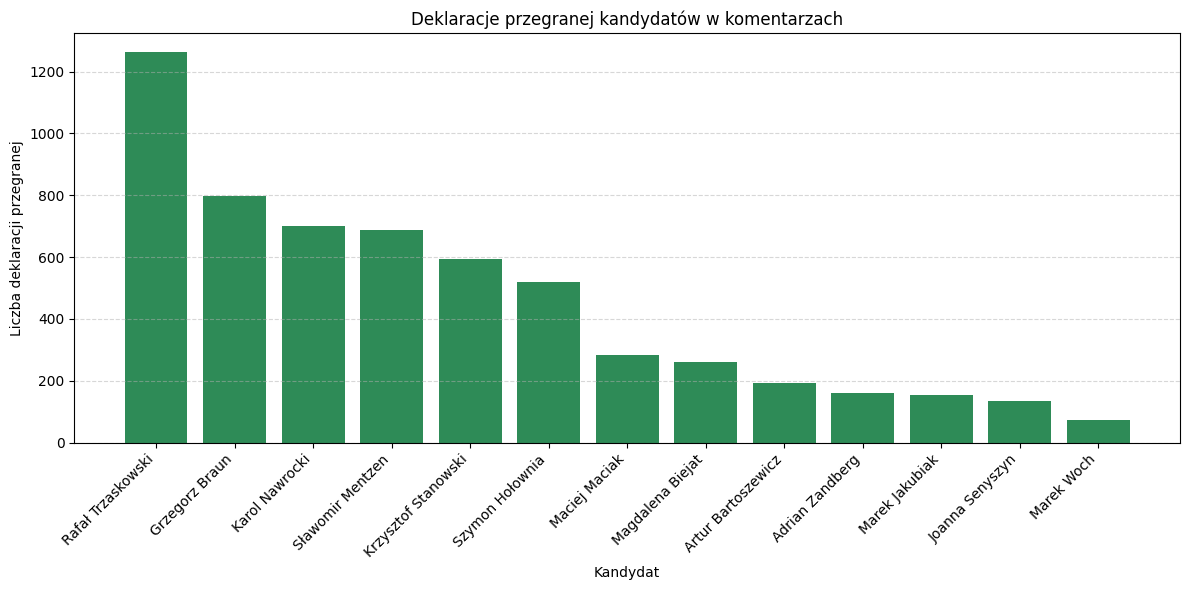

In [95]:
# Posortowanie wyników deklaracji przegranej kandydatów w kolejności malejącej
sorted_deklaracje_przegranej = dict(sorted(deklaracje_przegranej.items(), key=lambda x: x[1], reverse=True))

# Tworzenie wykresu przedstawiającego deklaracje przegranej kandydatów
plt.figure(figsize=(12, 6))
plt.bar(sorted_deklaracje_przegranej.keys(), sorted_deklaracje_przegranej.values(), color='seagreen')
plt.title("Deklaracje przegranej kandydatów w komentarzach")
plt.xlabel("Kandydat")
plt.ylabel("Liczba deklaracji przegranej")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [59]:
styl_pozytywny = [
    "konkretny", "merytoryczny", "opanowany", "spokojny", "zrównoważony", "przygotowany",
    "logiczny", "jasny przekaz", "dobrze mówi", "mówi do rzeczy", "trafny", "przemyślany",
    "z klasą", "profesjonalny", "naturalny", "autentyczny", "przekonujący", "rzeczowy",
    "zwięzły", "na temat", "bez lania wody", "dobrze się wypowiada", "wyważony",
    "inteligentny", "poukładany", "klarowny", "płynny", "dokładny"
]

In [60]:
# Inicjalizacja wyniku
deklaracje_pozytywne = {k: 0 for k in kandydaci}

# Analiza komentarzy
for komentarz in df["text"].astype(str):
    komentarz_lower = komentarz.lower()
    for kandydat, formy in kandydaci.items():
        if any(re.search(rf"\b{forma}\b", komentarz_lower) for forma in formy):
            if any(slowo in komentarz_lower for slowo in styl_pozytywny):
                deklaracje_pozytywne[kandydat] += 1

# Wyświetlenie wyników
for kandydat, liczba in sorted(deklaracje_pozytywne.items(), key=lambda x: x[1], reverse=True):
    print(f"{kandydat}: {liczba} deklaracji pozytywnych")

Grzegorz Braun: 353 deklaracji pozytywnych
Rafał Trzaskowski: 307 deklaracji pozytywnych
Karol Nawrocki: 248 deklaracji pozytywnych
Krzysztof Stanowski: 239 deklaracji pozytywnych
Sławomir Mentzen: 228 deklaracji pozytywnych
Artur Bartoszewicz: 173 deklaracji pozytywnych
Szymon Hołownia: 141 deklaracji pozytywnych
Marek Jakubiak: 90 deklaracji pozytywnych
Maciej Maciak: 75 deklaracji pozytywnych
Adrian Zandberg: 70 deklaracji pozytywnych
Magdalena Biejat: 51 deklaracji pozytywnych
Joanna Senyszyn: 43 deklaracji pozytywnych
Marek Woch: 33 deklaracji pozytywnych


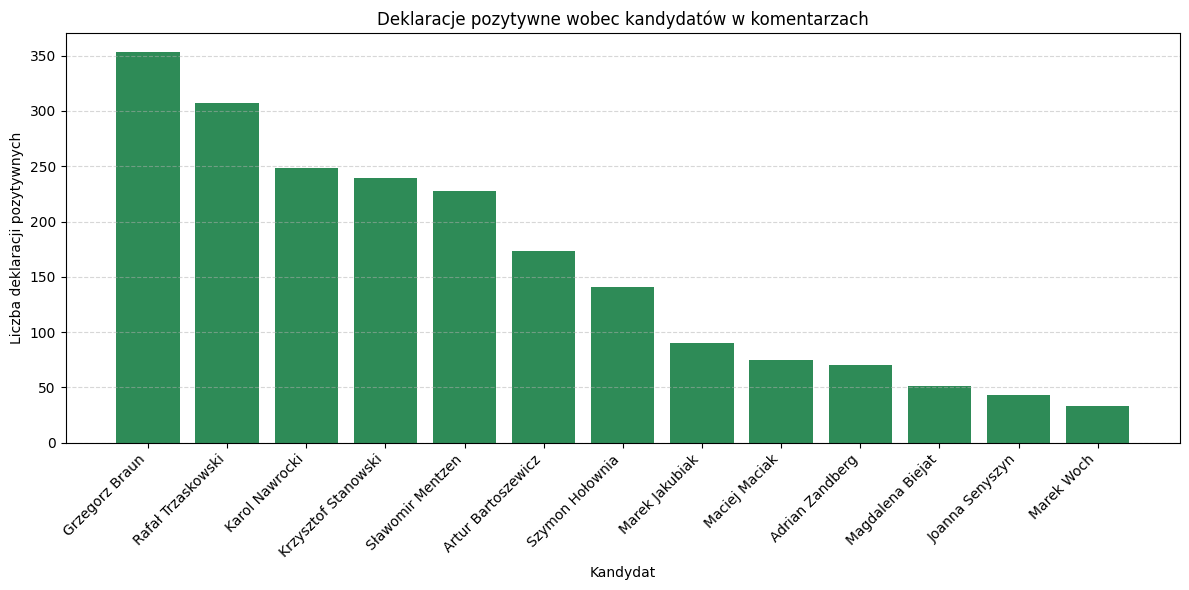

In [99]:
# Posortowanie wyników deklaracji pozytywnych kandydatów w kolejności malejącej
sorted_deklaracje_pozytywne = dict(sorted(deklaracje_pozytywne.items(), key=lambda x: x[1], reverse=True))

# Tworzenie wykresu
plt.figure(figsize=(12, 6))
plt.bar(sorted_deklaracje_pozytywne.keys(), sorted_deklaracje_pozytywne.values(), color='seagreen')
plt.title("Deklaracje pozytywne wobec kandydatów w komentarzach")
plt.xlabel("Kandydat")
plt.ylabel("Liczba deklaracji pozytywnych")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [62]:
synonimy_hejtu = [
    "idiota", "debil", "kretyn", "głupek", "tuman", "baran", "ciemniak", "głupi",
    "głupota", "idiotyzm", "paranoja", "żałosny", "śmieszny", "beznadziejny", "chory",
    "nienormalny", "psychol", "nienawiść", "nienawidzę", "nikt cię nie lubi",
    "zrób wszystkim przysługę", "zamilcz", "zamknij się", "tylko idioci na niego głosują",
    "co za pajac", "co za idiota", "jaki debil", "żałosne", "spadaj", "wypad", "won",
    "oszołom", "fanatyk", "hitler", "komunista", "lewak", "prawak", "czubek",
    "szkodnik", "zdrajca", "foliarz", "szur", "antyszczep", "prymityw", "matoł", "burak"
]


In [63]:
# Inicjalizacja wyniku
deklaracje_hejterskie = {k: 0 for k in kandydaci}

# Analiza komentarzy
for komentarz in df["text"].astype(str):
    komentarz_lower = komentarz.lower()
    for kandydat, formy in kandydaci.items():
        if any(re.search(rf"\b{forma}\b", komentarz_lower) for forma in formy):
            if any(slowo in komentarz_lower for slowo in synonimy_hejtu):
                deklaracje_hejterskie[kandydat] += 1

# Wyświetlenie wyników
for kandydat, liczba in sorted(deklaracje_hejterskie.items(), key=lambda x: x[1], reverse=True):
    print(f"{kandydat}: {liczba} deklaracji hejterskich")

Rafał Trzaskowski: 815 deklaracji hejterskich
Grzegorz Braun: 646 deklaracji hejterskich
Karol Nawrocki: 586 deklaracji hejterskich
Sławomir Mentzen: 579 deklaracji hejterskich
Szymon Hołownia: 492 deklaracji hejterskich
Krzysztof Stanowski: 422 deklaracji hejterskich
Maciej Maciak: 177 deklaracji hejterskich
Marek Jakubiak: 168 deklaracji hejterskich
Magdalena Biejat: 164 deklaracji hejterskich
Adrian Zandberg: 156 deklaracji hejterskich
Artur Bartoszewicz: 140 deklaracji hejterskich
Joanna Senyszyn: 129 deklaracji hejterskich
Marek Woch: 69 deklaracji hejterskich


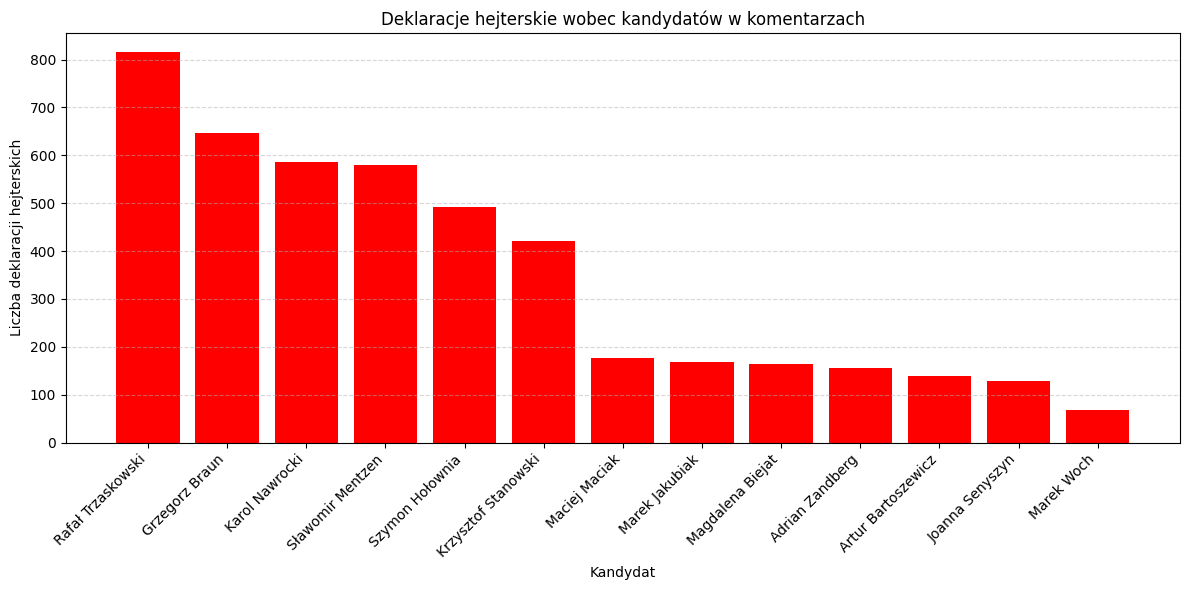

In [64]:
sorted_deklaracje_hejterskie = dict(sorted(deklaracje_hejterskie.items(), key=lambda x: x[1], reverse=True))

# Tworzenie wykresu
plt.figure(figsize=(12, 6))
plt.bar(sorted_deklaracje_hejterskie.keys(), sorted_deklaracje_hejterskie.values(), color='red')
plt.title("Deklaracje hejterskie wobec kandydatów w komentarzach")
plt.xlabel("Kandydat")
plt.ylabel("Liczba deklaracji hejterskich")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [68]:
emocje_negatywne = [
    "żałosny", "beznadziejny", "śmieszny", "chory", "nienormalny", "toksyczny",
    "ohydny", "obrzydliwy", "wstrętny", "niesmaczny", "odrażający", "wredny",
    "złośliwy", "kłamliwy", "fałszywy", "niegodny", "podejrzany", "nieludzki",
    "nieszczery", "arogancki", "butny", "chamski", "bezczelny", "zdemoralizowany",
    "skorumpowany", "podejrzany", "opętany", "frustrat", "agresywny", "mściwy",
    "karykaturalny", "gorszy sort", "hańba", "żenada", "tragedia", "patologia",
    "katastrofa", "porażka", "klęska", "nędzny", "słaby", "żałość", "toksyna",
    "syf", "zgnilizna", "gnój", "przegryw", "nieudacznik", "zwyrol", "słabiak",
    "bezwartościowy", "pusty", "nierealny", "nudny", "nieskuteczny", "nierealny",
    "obłudny", "bzdurny", "żałosność", "obciach", "dno", "najgorszy", "upadek"
]

In [69]:
# Inicjalizacja wyniku
deklaracje_negatywne = {k: 0 for k in kandydaci}

# Analiza komentarzy
for komentarz in df["text"].astype(str):
    komentarz_lower = komentarz.lower()
    for kandydat, formy in kandydaci.items():
        if any(re.search(rf"\b{forma}\b", komentarz_lower) for forma in formy):
            if any(slowo in komentarz_lower for slowo in emocje_negatywne):
                deklaracje_negatywne[kandydat] += 1

# Wyświetlenie wyników
for kandydat, liczba in sorted(deklaracje_negatywne.items(), key=lambda x: x[1], reverse=True):
    print(f"{kandydat}: {liczba} deklaracji negatywnych")

Rafał Trzaskowski: 873 deklaracji negatywnych
Grzegorz Braun: 611 deklaracji negatywnych
Karol Nawrocki: 498 deklaracji negatywnych
Sławomir Mentzen: 473 deklaracji negatywnych
Krzysztof Stanowski: 460 deklaracji negatywnych
Szymon Hołownia: 457 deklaracji negatywnych
Maciej Maciak: 223 deklaracji negatywnych
Magdalena Biejat: 171 deklaracji negatywnych
Artur Bartoszewicz: 161 deklaracji negatywnych
Marek Jakubiak: 117 deklaracji negatywnych
Adrian Zandberg: 115 deklaracji negatywnych
Joanna Senyszyn: 101 deklaracji negatywnych
Marek Woch: 52 deklaracji negatywnych


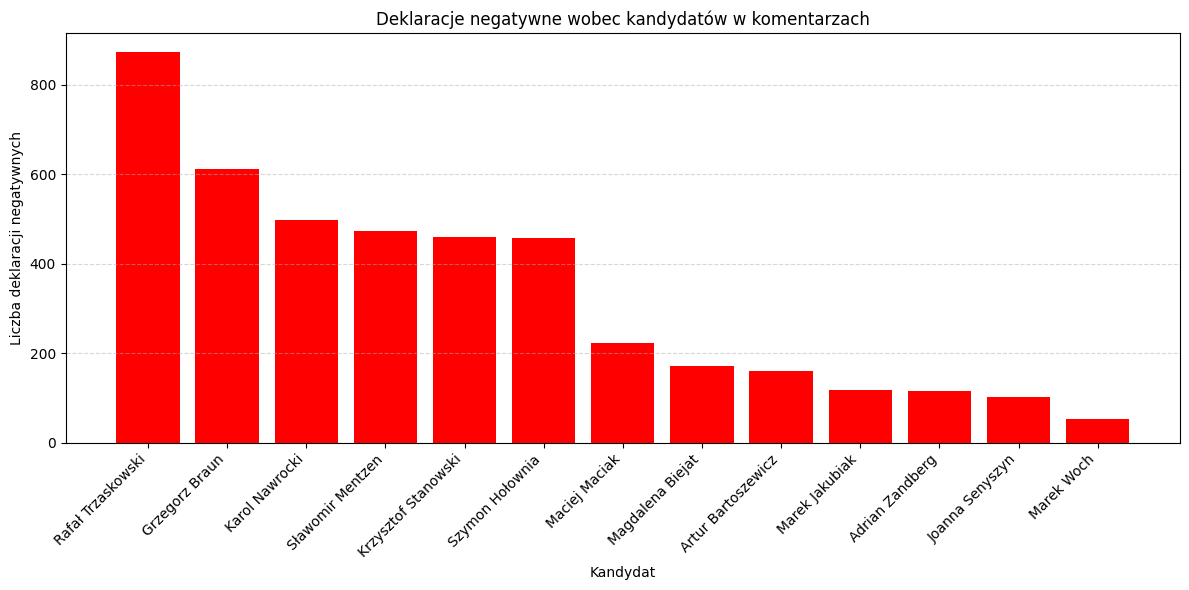

In [70]:
sorted_deklaracje_negatywne = dict(sorted(deklaracje_negatywne.items(), key=lambda x: x[1], reverse=True))

# Tworzenie wykresu
plt.figure(figsize=(12, 6))
plt.bar(sorted_deklaracje_negatywne.keys(), sorted_deklaracje_negatywne.values(), color='red')
plt.title("Deklaracje negatywne wobec kandydatów w komentarzach")
plt.xlabel("Kandydat")
plt.ylabel("Liczba deklaracji negatywnych")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

W dobie cyfrowej transformacji życia publicznego, prawdziwe pole debaty coraz częściej przenosi się z sal sejmowych i studiów telewizyjnych do przestrzeni internetowej. Platformy takie jak YouTube stają się nie tylko źródłem informacji, ale również barometrem społecznych emocji. To właśnie w komentarzach — często niekontrolowanych i spontanicznych — odzwierciedla się rzeczywisty puls społeczeństwa. Analiza 10 000 losowo wybranych komentarzy zamieszczonych pod filmami z debatą prezydencką 2025 dostarczyła cennych wniosków na temat tego, którzy kandydaci najbardziej przykuwają uwagę internautów, jak są odbierani i w jaki sposób się o nich mówi.
Grzegorz Braun – lider widoczności i polaryzacji

Najczęściej wymienianym nazwiskiem w komentarzach był Grzegorz Braun, co nie powinno dziwić biorąc pod uwagę jego kontrowersyjny styl wypowiedzi, radykalne poglądy i wyrazistą postawę medialną. Braun przyciąga uwagę zarówno swoich zwolenników, którzy chwalą go za "niezłomność" i "odwagę", jak i przeciwników — określających go mianem "fanatyka", "foliarza" czy "oszołoma". Co ciekawe, wielu komentatorów nie wyrażało wobec niego neutralności — jego nazwisko niemal zawsze pojawiało się w emocjonalnym kontekście. To pokazuje, jak silnie polaryzująca postacią jest ten kandydat.
Sławomir Mentzen – mobilizacja młodego elektoratu i styl TikTokowy

Na drugim miejscu uplasował się Sławomir Mentzen, jeden z liderów Konfederacji, który z dużym powodzeniem prowadzi kampanię skierowaną do młodego, często internetowego elektoratu. Komentarze na jego temat były częste i nacechowane dużą ilością deklaracji poparcia, ale również krytyką stylu komunikacji, który nie wszystkim przypadł do gustu. Mentzen jawił się w komentarzach jako kandydat "merytoryczny i konkretny" lub przeciwnie — jako "sprytny manipulator", który "dobrze mówi, ale nic nie zmieni". Często przywoływano również jego działania w mediach społecznościowych, głównie na TikToku, co czyni go jednym z najnowocześniej komunikujących się kandydatów tej kampanii.
Szymon Hołownia – trzecia siła czy wygasająca nadzieja?

Na trzecim miejscu wśród najczęściej wspominanych nazwisk znalazł się Szymon Hołownia. Komentarze na jego temat często odwoływały się do jego przeszłości dziennikarsko-publicystycznej, a także do wizerunku "umiarkowanego, przyjaznego kandydata", który "nie dzieli, tylko szuka porozumienia". Jednak równie często pojawiały się zarzuty o "brak konkretów", "zbyt miękkie podejście" lub "brak autentyczności". Hołownia był często porównywany z kandydatami bardziej wyrazistymi, jak Braun czy Mentzen, co unaocznia jego pozycję jako kandydata centrowego, ale być może zbyt łagodnego, by przyciągnąć emocjonalnie zaangażowany elektorat.
Kolejni kandydaci: Trzaskowski, Nawrocki, Stanowski

Rafał Trzaskowski, choć dobrze rozpoznawalny, nie zdobył w tej analizie równie wysokiego poziomu zaangażowania w komentarzach. Pojawiał się w kontekście zarzutów o "partyjność", "powiązania z elitami" oraz jako symbol "establishmentu". Jego obecność w analizowanej próbce była częściej neutralna lub negatywna niż entuzjastyczna.

Karol Nawrocki, wspierany przez obóz rządzący, był komentowany raczej zdawkowo — często w formie pytań typu "kto to jest?" lub "skąd on się wziął?". Mimo że reprezentuje siły mające dostęp do szerokiego zaplecza medialnego, jego nazwisko nie wywoływało silnych emocji.

Z kolei Krzysztof Stanowski, startujący jako kandydat niezależny i znany dziennikarz sportowy, był komentowany głównie w tonie ciekawostki lub internetowego fenomenu. Nie brakowało głosów żartobliwych, ale i takich, które sugerowały, że jego obecność w debacie "odświeża" dyskusję publiczną i przyciąga młodszych widzów.
Kandydaci z mniejszą widocznością i rola memów

W dalszej części zestawienia znaleźli się m.in. Joanna Senyszyn, Adrian Zandberg, Magdalena Biejat, Maciej Maciak czy Piotr Bartoszewicz. Ich nazwiska pojawiały się znacznie rzadziej i najczęściej w komentarzach o charakterze informacyjnym, z rzadka emocjonalnych. W ich przypadku zauważalna była większa liczba przezwisk, skrótów i etykiet ideologicznych, niż pełnych nazwisk — co pokazuje, że część kandydatów funkcjonuje w świadomości wyborców bardziej jako "mem" niż realna alternatywa wyborcza.